# Homework 3 - Question 4 - Luke Arend

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.fft import fft, ifft, fftshift
from scipy.io import loadmat

Load the file `myMeasurements.mat` into Matlab. It contains a vector, `sig`, containing voltage values measured from an EEG electrode, sampled at 120 Hz.

In [75]:
obj = loadmat('hw3/myMeasurements.mat')
sig = np.squeeze(obj['sig'])
t = np.squeeze(obj['time'] / 120)

Plot `sig` as a function of vector time (time, in seconds), using the flag `'ko-'` in matlab’s plot command so you can see the samples.

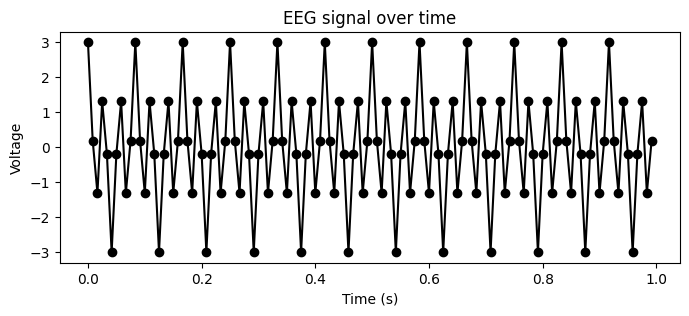

In [76]:
plt.subplots(figsize=(8, 3))
plt.title('EEG signal over time')
plt.plot(t, sig, 'ko-')
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

# a)

The voltage signal is densely sampled (120 Hz), and thus expensive to store. Create a subsampled version of the signal, which contains every fourth value. Plot this, against the corresponding entries of the time vector, on top of the original data (use matlab’s `hold` function, and plot with flag `'r*-'`).

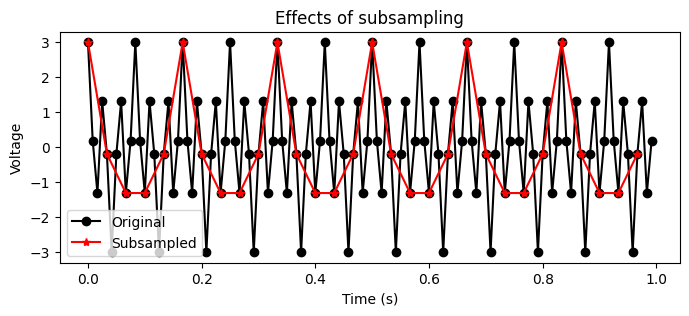

In [77]:
def subsample(x, factor=4, offset=0):
    return x[offset::factor]

plt.subplots(figsize=(8, 3))
plt.title('Effects of subsampling')
plt.plot(t, sig, 'ko-', label='Original')
plt.plot(subsample(t), subsample(sig), 'r*-', label='Subsampled')
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.legend()
plt.show()

Is the subsampling operation linear? Shift-invariant?

It's easy enough to see that subsampled(A + B) = subsampled(A) + subsampled(B), so subsampling **is linear**. However, subsampling starting from index 0 gives a different result than subsampling starting from index 1. So subsampling **is not shift-invariant**.

How does this reduced version of the data look, compared to the original? Does it provide a good summary of the original measurements? Explain.

The subsampled signal is aliased, showing a low frequency not present in the original data. In this case subsampling **does not** provide a good estimate of the signal since the frequencies in the original signal exceed the sampling rate.

# b)

Examine your EEG result in the frequency domain. First plot the magnitude (amplitude) of the Fourier transform of the original signal, over the range $[−N/2, (N/2) − 1]$ (use `fftshift`).

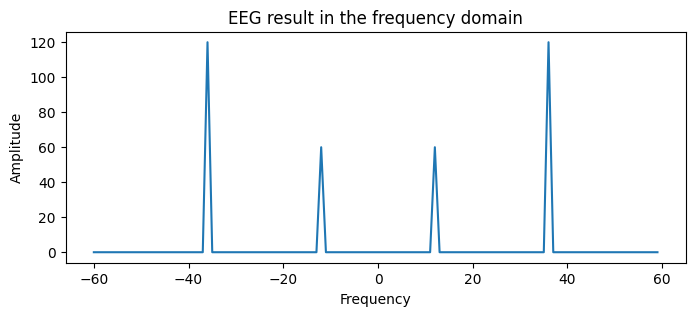

In [80]:
amplitude = np.abs(fft(sig))
nfreqs = len(amplitude)
freqs = np.arange(nfreqs) - nfreqs // 2
plt.subplots(figsize=(8, 3))
plt.plot(freqs, fftshift(amplitude))
plt.title('EEG result in the frequency domain')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

By convention, the “Delta” band corresponds to frequencies less than 4 Hz, “Theta” band is 4-7 Hz, “Alpha” band 8-15 Hz, and “Beta” is 16-31 Hz. For these data, which band shows the strongest signal? Is there any power in frequencies outside of these known bands, and if so can you explain the origin of this part of the signal?

In [79]:
peaks = amplitude[:nfreqs // 2] > 0.01
np.nonzero(peaks)[0]

array([12, 36])

There is power at the frequencies 12 Hz and 36 Hz. The 12 Hz frequency is within the alpha band. 36 Hz is a bit above (and outside) the beta band. In the original signal, the high-frequency component has a cycle length around 3 1/3 line segments. Dividing the length of the whole signal (120 samples/sec), by this period (3.33 samples/cycle), gives 36 cycles/second, explaining the 36 Hz component present in the Fourier transform.

# c)

Write a function `signalPart = bandWiseReconstruct(bandName)` that reconstructs the signal (and plots the reconstruction) using only sinusoids from the band corresponding to the string `bandName` (i.e. for `bandName = 'Delta'` the reconstruction should be a sum of sinusoids with frequencies from 0-4 Hz).

In [39]:
freq_bands = {
    'Delta': [0, 4],
    'Theta': [4, 7],
    'Alpha': [8, 15],
    'Beta': [16, 31]
}

def bandwise_reconstruct(band_name):
    start, end = freq_bands[band_name]
    middle = nfreqs // 2
    mask = np.zeros(nfreqs, dtype='bool')
    mask[start:end] = 1
    mask[middle + start:middle + end] = 1

    part_fft = np.zeros(nfreqs, dtype='complex')
    part_fft[mask] = fft(sig)[mask]
    signal_part = ifft(part_fft)

    plt.subplots(figsize=(8, 3))
    plt.title(f"Reconstructed EEG signal ('{band_name}' band only)")
    plt.plot(t, np.real(signal_part), 'ko-')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage')
    return signal_part

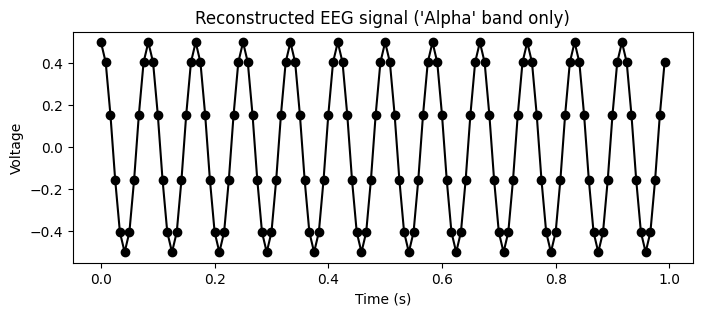

In [46]:
reconstructed = bandwise_reconstruct('Alpha')

# d)

Plot the Fourier magnitude for signals downsampled by factors of 2, 3, and 4, after upsampling them back to full size (i.e., make a full-size signal filled with zeros, and set every $k$th sample equal to one of the subsampled values, for subsampling by factor $k$).

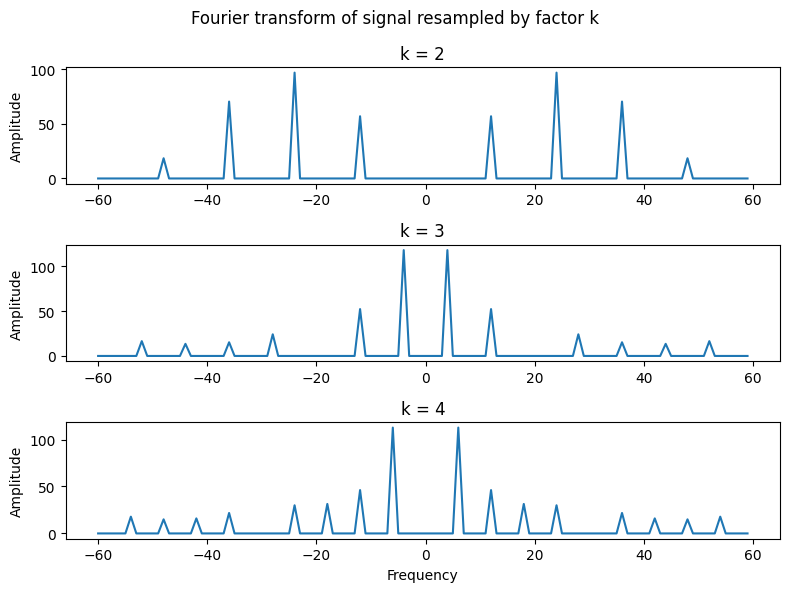

In [73]:
signals = []
for k in [2, 3, 4]:
    subsampled = subsample(sig, factor=k)
    resampled = np.zeros(nfreqs)
    for offset in range(k):
        resampled[offset::k] = subsampled
    signals.append(resampled)

fig, axs = plt.subplots(3, 1, figsize=(8, 6))
plt.suptitle('Fourier transform of signal resampled by factor k')
freqs = np.arange(nfreqs) - nfreqs // 2
for i in range(3):
    plt.sca(axs[i])
    plt.title(f'k = {i + 2}')
    plt.plot(freqs, fftshift(np.abs(fft(signals[i]))))
    plt.ylabel('Amplitude')
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

What is the relationship between these plots and the original frequency plot?

These plots contain peaks at the same frequencies as the original signal, but also have **new peaks at frequencies not present in the original**. These are artifacts due to resampling.

What has happened to the frequency components of the original signal?

The frequency components of the original signal remain **present but they are rescaled**. In general they are reduced as some power from their bands has migrated to the new frequency bands that were not present in the original signal.

Does the strongest signal band change?

**Yes.** The strongest band in the original signal was at 36 Hz, but the strongest band in each resampled version of the signal differs from all the others.